# QWOP Project 5

This project involves a few codes, in the following, the physics engine is not required for you to understand, you just need to know, this engine works whenever you feed a 40 floating point array (list) to this function. 

For you ease of use, I provided a data-collection free version of the following code, which is called ``QWOP`` in the next block.

In [1]:
# This code is based on an assignment designed by Paul Valiant.  
# Please do not disseminate this code without his written permission.
#
# This python implementation was written by Okke Schrijvers

import sys
import math
import numpy as np
import time
from matplotlib import pyplot as plt
from matplotlib import animation
import copy
import random

# plan is an array of 40 floating point numbers

def sim(plan):
    data = []
    for i in range(0, len(plan)):
        if plan[i] > 1:
            plan[i] = 1.0
        elif plan[i] < -1:
            plan[i] = -1.0

    dt = 0.1
    friction = 1.0
    gravity = 0.1
    mass = [30, 10, 5, 10, 5, 10]
    edgel = [0.5, 0.5, 0.5, 0.5, 0.9]
    edgesp = [160.0, 180.0, 160.0, 180.0, 160.0]
    edgef = [8.0, 8.0, 8.0, 8.0, 8.0]
    anglessp = [20.0, 20.0, 10.0, 10.0]
    anglesf = [8.0, 8.0, 4.0, 4.0]
    
    edge = [(0, 1),(1, 2),(0, 3),(3, 4),(0, 5)]
    angles = [(4, 0),(4, 2),(0, 1),(2, 3)]
    
    # vel and pos of the body parts, 0 is hip, 5 is head, others are joints
    v = [[0.0,0.0,0.0,0.0,0.0,0.0], [0.0,0.0,0.0,0.0,0.0,0.0]]
    p = [[0, 0, -.25, .25, .25, .15], [1, .5, 0, .5, 0, 1.9]]
    
    spin = 0.0
    maxspin = 0.0
    lastang = 0.0
    
    for j in range(20):
        for k in range(10):
            lamb = 0.05 + 0.1*k
            t0 = 0.5
            if j>0:
                t0 = plan[2*j-2]
            t0 *= (1-lamb)
            t0 += plan[2*j]*lamb
            
            t1 = 0.0
            if j>0:
                t1 = plan[2*j-1]
            t1 *= (1-lamb)
            t1 += plan[2*j+1]*lamb
            
            

            contact = [False,False,False,False,False,False]
            for z in range(6):
                if p[1][z] <= 0:
                    contact[z] = True
                    spin = 0
                    p[1][z] = 0

            anglesl = [-(2.8+t0), -(2.8-t0), -(1-t1)*.9, -(1+t1)*.9]

            disp = [[0,0,0,0,0],[0,0,0,0,0]]
            dist = [0,0,0,0,0]
            dispn = [[0,0,0,0,0],[0,0,0,0,0]]
            for z in range(5):
                disp[0][z] = p[0][edge[z][1]]-p[0][edge[z][0]]
                disp[1][z] = p[1][edge[z][1]]-p[1][edge[z][0]]
                dist[z] = math.sqrt(disp[0][z]*disp[0][z] + disp[1][z]*disp[1][z])
                inv = 1.0/dist[z];
                dispn[0][z] = disp[0][z]*inv
                dispn[1][z] = disp[1][z]*inv;
        
            dispv = [[0,0,0,0,0],[0,0,0,0,0]]
            distv = [0,0,0,0,0]
            for z in range(5):
                dispv[0][z] = v[0][edge[z][1]] - v[0][edge[z][0]]
                dispv[1][z] = v[1][edge[z][1]] - v[1][edge[z][0]]
                distv[z] = 2*(disp[0][z]*dispv[0][z] + disp[1][z]*dispv[1][z])

            
            forceedge = [[0,0,0,0,0],[0,0,0,0,0]]
            for z in range(5):
                c = (edgel[z]-dist[z])*edgesp[z]-distv[z]*edgef[z]
                forceedge[0][z] = c*dispn[0][z]
                forceedge[1][z] = c*dispn[1][z]

            edgeang = [0,0,0,0,0]
            edgeangv = [0,0,0,0,0]
            for z in range(5):
                edgeang[z] = math.atan2(disp[1][z], disp[0][z])
                edgeangv[z] = (dispv[0][z]*disp[1][z]-dispv[1][z]*disp[0][z])/(dist[z]*dist[z])

            inc = edgeang[4] - lastang
            if (inc < -math.pi):
                inc += 2.0 * math.pi
            elif inc > math.pi:
                inc -= 2.0 * math.pi
            spin += inc
            spinc = spin - .005*(k + 10 * j)
            if spinc > maxspin:
                maxspin = spinc
                lastang = edgeang[4]

            angv = [0,0,0,0]
            for z in range(4):
                angv[z] = edgeangv[angles[z][1]]-edgeangv[angles[z][0]];

            angf = [0,0,0,0]
            for z in range(4):
                ang = edgeang[angles[z][1]]-edgeang[angles[z][0]]-anglesl[z]
                if ang > math.pi:
                    ang -= 2*math.pi
                elif ang < -math.pi:
                    ang += 2*math.pi
                m0 = dist[angles[z][0]]/edgel[angles[z][0]]
                m1 = dist[angles[z][1]]/edgel[angles[z][1]]
                angf[z] = ang*anglessp[z]-angv[z]*anglesf[z]*min(m0,m1)

            edgetorque = [[0,0,0,0,0],[0,0,0,0,0]]
            for z in range(5):
                inv = 1.0 / (dist[z]*dist[z])
                edgetorque[0][z] = -disp[1][z]*inv
                edgetorque[1][z] =  disp[0][z]*inv

            for z in range(4):
                i0 = angles[z][0]
                i1 = angles[z][1]
                forceedge[0][i0] += angf[z]*edgetorque[0][i0]
                forceedge[1][i0] += angf[z]*edgetorque[1][i0]
                forceedge[0][i1] -= angf[z]*edgetorque[0][i1]
                forceedge[1][i1] -= angf[z]*edgetorque[1][i1]

            f = [[0,0,0,0,0,0],[0,0,0,0,0,0]]
            for z in range(5):
                i0 = edge[z][0]
                i1 = edge[z][1]
                f[0][i0] -= forceedge[0][z]
                f[1][i0] -= forceedge[1][z]
                f[0][i1] += forceedge[0][z]
                f[1][i1] += forceedge[1][z]

            for z in range(6):
                f[1][z] -= gravity*mass[z]
                invm = 1.0/mass[z]
                v[0][z] += f[0][z]*dt*invm
                v[1][z] += f[1][z]*dt*invm
                
                if contact[z]:
                    fric = 0.0
                    if v[1][z] < 0.0:
                        fric = -v[1][z]
                        v[1][z] = 0.0

                    s = np.sign(v[0][z])
                    if v[0][z]*s < fric*friction:
                        v[0][z]=0
                    else:
                        v[0][z] -= fric*friction*s
                p[0][z] += v[0][z] * dt
                p[1][z] += v[1][z] * dt;

            data.append(copy.deepcopy(p))


            if contact[0] or contact[5]:
                return p[0][5], data 
    return p[0][5], data



def visualize(plan):
    distance, data = sim(plan)
    print('total distance traveled {dis}'.format(dis=distance))

    # draw the simulation
    fig = plt.figure()
    fig.set_dpi(100)
    fig.set_size_inches(12, 3)

    ax = plt.axes(xlim=(-1, 10), ylim=(0, 3))

    joints = [5, 0, 1, 2, 1, 0, 3, 4]
    patch = plt.Polygon([[0,0],[0,0]],closed=None, fill=None, edgecolor='k')
    head = plt.Circle((0, 0), radius=0.15, fc='k', ec='k')

    def init():
        ax.add_patch(patch)
        ax.add_patch(head)
        return patch,head


    def animate(j):
        points = np.array([[data[j][0][i] for i in joints], [data[j][1][i] for i in joints]]).T
        patch.set_xy(points)
        head.center = (data[j][0][5], data[j][1][5])
        return patch,head

    anim = animation.FuncAnimation(fig, animate,
                                   init_func=init,
                                   frames=len(data),
                                   interval=20, blit=True)
    anim.save('animation.mp4', fps=50,extra_args=['-vcodec', 'libx264'])

    plt.show()

## Visualize your result

total distance traveled -0.1980853066954051


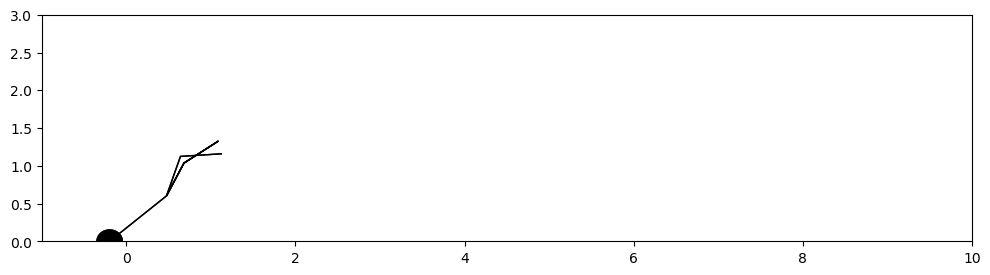

In [4]:
###########
# The following code is given as an example to store a video of the run and to display
# the run in a graphics window. You will treat sim(plan) as a black box objective
# function and minimize it.
###########

# supply with 40 floating point numbers
plan = [random.uniform(-1,1) for i in range(40)]

# this code will generate a video at your local directory for your result and print out the result.
visualize(plan)

##  The data-collection-free version of the previous code

In [5]:
# In this code, the data collection is removed for speed consideration. 
# So this function is suitable for your optimization. 

def QWOP(plan):
    for i in range(0, len(plan)):
        if plan[i] > 1:
            plan[i] = 1.0
        elif plan[i] < -1:
            plan[i] = -1.0

    dt = 0.1
    friction = 1.0
    gravity = 0.1
    mass = [30, 10, 5, 10, 5, 10]
    edgel = [0.5, 0.5, 0.5, 0.5, 0.9]
    edgesp = [160.0, 180.0, 160.0, 180.0, 160.0]
    edgef = [8.0, 8.0, 8.0, 8.0, 8.0]
    anglessp = [20.0, 20.0, 10.0, 10.0]
    anglesf = [8.0, 8.0, 4.0, 4.0]
    
    edge = [(0, 1),(1, 2),(0, 3),(3, 4),(0, 5)]
    angles = [(4, 0),(4, 2),(0, 1),(2, 3)]
    
    # vel and pos of the body parts, 0 is hip, 5 is head, others are joints
    v = [[0.0,0.0,0.0,0.0,0.0,0.0], [0.0,0.0,0.0,0.0,0.0,0.0]]
    p = [[0, 0, -.25, .25, .25, .15], [1, .5, 0, .5, 0, 1.9]]
    
    spin = 0.0
    maxspin = 0.0
    lastang = 0.0
    
    for j in range(20):
        for k in range(10):
            lamb = 0.05 + 0.1*k
            t0 = 0.5
            if j>0:
                t0 = plan[2*j-2]
            t0 *= (1-lamb)
            t0 += plan[2*j]*lamb
            
            t1 = 0.0
            if j>0:
                t1 = plan[2*j-1]
            t1 *= (1-lamb)
            t1 += plan[2*j+1]*lamb
            
            

            contact = [False,False,False,False,False,False]
            for z in range(6):
                if p[1][z] <= 0:
                    contact[z] = True
                    spin = 0
                    p[1][z] = 0

            anglesl = [-(2.8+t0), -(2.8-t0), -(1-t1)*.9, -(1+t1)*.9]

            disp = [[0,0,0,0,0],[0,0,0,0,0]]
            dist = [0,0,0,0,0]
            dispn = [[0,0,0,0,0],[0,0,0,0,0]]
            for z in range(5):
                disp[0][z] = p[0][edge[z][1]]-p[0][edge[z][0]]
                disp[1][z] = p[1][edge[z][1]]-p[1][edge[z][0]]
                dist[z] = math.sqrt(disp[0][z]*disp[0][z] + disp[1][z]*disp[1][z])
                inv = 1.0/dist[z];
                dispn[0][z] = disp[0][z]*inv
                dispn[1][z] = disp[1][z]*inv;
        
            dispv = [[0,0,0,0,0],[0,0,0,0,0]]
            distv = [0,0,0,0,0]
            for z in range(5):
                dispv[0][z] = v[0][edge[z][1]] - v[0][edge[z][0]]
                dispv[1][z] = v[1][edge[z][1]] - v[1][edge[z][0]]
                distv[z] = 2*(disp[0][z]*dispv[0][z] + disp[1][z]*dispv[1][z])

            
            forceedge = [[0,0,0,0,0],[0,0,0,0,0]]
            for z in range(5):
                c = (edgel[z]-dist[z])*edgesp[z]-distv[z]*edgef[z]
                forceedge[0][z] = c*dispn[0][z]
                forceedge[1][z] = c*dispn[1][z]

            edgeang = [0,0,0,0,0]
            edgeangv = [0,0,0,0,0]
            for z in range(5):
                edgeang[z] = math.atan2(disp[1][z], disp[0][z])
                edgeangv[z] = (dispv[0][z]*disp[1][z]-dispv[1][z]*disp[0][z])/(dist[z]*dist[z])

            inc = edgeang[4] - lastang
            if (inc < -math.pi):
                inc += 2.0 * math.pi
            elif inc > math.pi:
                inc -= 2.0 * math.pi
            spin += inc
            spinc = spin - .005*(k + 10 * j)
            if spinc > maxspin:
                maxspin = spinc
                lastang = edgeang[4]

            angv = [0,0,0,0]
            for z in range(4):
                angv[z] = edgeangv[angles[z][1]]-edgeangv[angles[z][0]];

            angf = [0,0,0,0]
            for z in range(4):
                ang = edgeang[angles[z][1]]-edgeang[angles[z][0]]-anglesl[z]
                if ang > math.pi:
                    ang -= 2*math.pi
                elif ang < -math.pi:
                    ang += 2*math.pi
                m0 = dist[angles[z][0]]/edgel[angles[z][0]]
                m1 = dist[angles[z][1]]/edgel[angles[z][1]]
                angf[z] = ang*anglessp[z]-angv[z]*anglesf[z]*min(m0,m1)

            edgetorque = [[0,0,0,0,0],[0,0,0,0,0]]
            for z in range(5):
                inv = 1.0 / (dist[z]*dist[z])
                edgetorque[0][z] = -disp[1][z]*inv
                edgetorque[1][z] =  disp[0][z]*inv

            for z in range(4):
                i0 = angles[z][0]
                i1 = angles[z][1]
                forceedge[0][i0] += angf[z]*edgetorque[0][i0]
                forceedge[1][i0] += angf[z]*edgetorque[1][i0]
                forceedge[0][i1] -= angf[z]*edgetorque[0][i1]
                forceedge[1][i1] -= angf[z]*edgetorque[1][i1]

            f = [[0,0,0,0,0,0],[0,0,0,0,0,0]]
            for z in range(5):
                i0 = edge[z][0]
                i1 = edge[z][1]
                f[0][i0] -= forceedge[0][z]
                f[1][i0] -= forceedge[1][z]
                f[0][i1] += forceedge[0][z]
                f[1][i1] += forceedge[1][z]

            for z in range(6):
                f[1][z] -= gravity*mass[z]
                invm = 1.0/mass[z]
                v[0][z] += f[0][z]*dt*invm
                v[1][z] += f[1][z]*dt*invm
                
                if contact[z]:
                    fric = 0.0
                    if v[1][z] < 0.0:
                        fric = -v[1][z]
                        v[1][z] = 0.0

                    s = np.sign(v[0][z])
                    if v[0][z]*s < fric*friction:
                        v[0][z]=0
                    else:
                        v[0][z] -= fric*friction*s
                p[0][z] += v[0][z] * dt
                p[1][z] += v[1][z] * dt;

            if contact[0] or contact[5]:
                return p[0][5]
    return p[0][5]

## Two examples
This shows the ``QWOP`` function can be used as a black box. You simply feed the vector, it provides the result.

In [6]:
## Example to run. 
plan = [random.uniform(-1,1) for i in range(40)]
distance = QWOP(plan)
print('distance is', distance)

distance is 0.041379382926911144


In [7]:
## Another simple example 
plan = [0.8146596195587961, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9299799161227229, 
        -1.0, -1.0, 1.0, -0.24063120422494988, 0.6, -0.02760975817227762, 
        0.5225867130210777, -0.1033263765212999, 0.24452788836722594, 1.0, 
        -1.0, -0.6959375786169501, -1.0, -1.0, 1.0, -1.0, -0.3672559410315137,
        1.0, -0.4580550218179207, -0.564153128318353, 0.2288497469922563, 
        -0.7934974499536618, -0.5884611584299589, -0.5817462224057366, 1.0, 
        1.0, -1.0, 0.6688343618956203, -0.7300544474718874, 
        -0.4733430075818795, 0.538893848041849, 1.0]

distance = QWOP(plan)
print('distance is', distance)

distance is 4.556958763792956


## Your task to implement

In [8]:
pop = np.random.uniform(low=-1.0, high=1.0, size=(1,40))
F = []
for i in range(len(pop)):
    F.append(-QWOP(pop[i]))
Fbest = max(F)
Fbest

-1.0198706800570465

In [9]:
def de(objFunc, popSize, crossProb, mutantWeight, maxIter):
    X = np.random.uniform(low=-1.0, high=1.0, size=(popSize,40))
    F = []
    for i in range(popSize):
            F.append(-objFunc(X[i]))
    Fbest = min(F)
    k = 0
    y = []
    
    while k < maxIter:
        for i in range(popSize):
            XL = X[i]
            opts = np.arange(popSize)
            opts = np.delete(opts,i)
            cands = np.random.choice(opts,size=(1,3))
            XA = X[cands[0][1]]
            XB = X[cands[0][1]]
            XC = X[cands[0][1]]
            R = np.random.choice(np.arange(len(XL))+1,size=(1,1))[0][0]
            for j in np.arange(len(XL))+1:
                rj = np.random.uniform()
                if rj < crossProb:
                    y.append(XA + mutantWeight*(XB - XC))
                    if y[j] > 1:
                        y[j] = 1
                    elif y[j] < -1:
                        y[j] = -1
                else:
                    y.append(XL[j])
            if -objFunc(y) < -objFunc(XL):
                X[i] = y
        for i in range(popSize):
            F.append(-objFunc(X[i]))
        Fbest = min(F)
        k += 1

In [10]:
de(QWOP,20,0.7,0.8,1000)

IndexError: list index out of range